# 只用 numpy & pandas

In [1]:
# 第 0 步：匯入套件（只用 numpy & pandas）
import numpy as np
import pandas as pd

# 為了讓每次執行結果一致
np.random.seed(42)


In [3]:
df = pd.read_csv("Data/mnist_test.csv", header=None)

print("Data shape:", df.shape)   # 例如 (10000, 785)
df.head()


Data shape: (10000, 785)


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# 把 DataFrame 變成 numpy 陣列
data = df.values.astype(np.float32)

# 第 0 欄是標籤（0~9）
y = data[:, 0].astype(int)

# 第 1~784 欄是像素
X = data[:, 1:]

# 像素從 0~255 正規化到 0~1
X = X / 255.0

print("X shape:", X.shape)   # (10000, 784)
print("y shape:", y.shape)   # (10000,)

# 切訓練 / 測試 (8:2)
num_samples = X.shape[0]
num_train = int(num_samples * 0.8)

X_train, X_test = X[:num_train], X[num_train:]
y_train, y_test = y[:num_train], y[num_train:]

print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)

# One-hot 編碼
num_classes = 10

def one_hot_encode(labels, num_classes):
    n = labels.shape[0]
    one_hot = np.zeros((n, num_classes), dtype=np.float32)
    one_hot[np.arange(n), labels] = 1.0
    return one_hot

y_train_onehot = one_hot_encode(y_train, num_classes)
y_test_onehot = one_hot_encode(y_test, num_classes)

print("Example label & one-hot:", y_train[0], y_train_onehot[0])


X shape: (10000, 784)
y shape: (10000,)
Train: (8000, 784) (8000,)
Test: (2000, 784) (2000,)
Example label & one-hot: 7 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [5]:
class SimpleNN:
    def __init__(self, input_dim, hidden_dim, output_dim, learning_rate=0.1):
        # Xavier 初始化（簡易版）
        self.W1 = np.random.randn(input_dim, hidden_dim) / np.sqrt(input_dim)
        self.b1 = np.zeros((1, hidden_dim))
        self.W2 = np.random.randn(hidden_dim, output_dim) / np.sqrt(hidden_dim)
        self.b2 = np.zeros((1, output_dim))
        self.lr = learning_rate

    def relu(self, z):
        return np.maximum(0, z)

    def relu_grad(self, z):
        return (z > 0).astype(np.float32)

    def softmax(self, z):
        z_shift = z - np.max(z, axis=1, keepdims=True)
        exp_scores = np.exp(z_shift)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return probs

    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.relu(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.softmax(self.z2)
        return self.a2

    def compute_loss(self, y_true_onehot, y_pred_prob):
        eps = 1e-10
        N = y_true_onehot.shape[0]
        log_probs = -np.log(y_pred_prob + eps)
        loss = np.sum(y_true_onehot * log_probs) / N
        return loss

    def backward(self, X, y_true_onehot):
        N = X.shape[0]
        # softmax + cross-entropy 的梯度
        delta2 = (self.a2 - y_true_onehot) / N

        dW2 = np.dot(self.a1.T, delta2)
        db2 = np.sum(delta2, axis=0, keepdims=True)

        delta1 = np.dot(delta2, self.W2.T) * self.relu_grad(self.z1)

        dW1 = np.dot(X.T, delta1)
        db1 = np.sum(delta1, axis=0, keepdims=True)

        # SGD 更新
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1

    def predict(self, X):
        probs = self.forward(X)
        return np.argmax(probs, axis=1)


In [6]:
input_dim = X_train.shape[1]   # 784
hidden_dim = 128
output_dim = 10
learning_rate = 0.1
batch_size = 64
epochs = 5   # 先少一點，跑快；熟悉後可以加大

model = SimpleNN(input_dim, hidden_dim, output_dim, learning_rate)

num_train = X_train.shape[0]
num_batches = num_train // batch_size

for epoch in range(1, epochs + 1):
    indices = np.arange(num_train)
    np.random.shuffle(indices)

    X_train_shuffled = X_train[indices]
    y_train_onehot_shuffled = y_train_onehot[indices]

    epoch_loss = 0.0

    for i in range(num_batches):
        start = i * batch_size
        end = start + batch_size

        X_batch = X_train_shuffled[start:end]
        y_batch = y_train_onehot_shuffled[start:end]

        y_pred = model.forward(X_batch)
        loss = model.compute_loss(y_batch, y_pred)
        epoch_loss += loss

        model.backward(X_batch, y_batch)

    # 簡單看一下訓練準確率（用全部訓練資料或前一部分都可以）
    y_train_pred = model.predict(X_train)
    train_acc = np.mean(y_train_pred == y_train)

    print(f"Epoch {epoch}/{epochs}, loss = {epoch_loss/num_batches:.4f}, train_acc = {train_acc:.4f}")


Epoch 1/5, loss = 0.9128, train_acc = 0.8765
Epoch 2/5, loss = 0.4040, train_acc = 0.9045
Epoch 3/5, loss = 0.3305, train_acc = 0.9110
Epoch 4/5, loss = 0.2901, train_acc = 0.9266
Epoch 5/5, loss = 0.2590, train_acc = 0.9336


In [7]:
y_test_pred = model.predict(X_test)
test_acc = np.mean(y_test_pred == y_test)

print("Test accuracy:", test_acc)


Test accuracy: 0.9335


# 使用Keras

In [ ]:
import numpy as np
import pandas as pd
from tensorflow import keras
from keras import layers


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Vibe Coding/data/mnist_test.csv", header=None)

print("Data shape:", df.shape)   # 例如 (10000, 785)
df.head()

Data shape: (10000, 785)


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# 第 0 欄是標籤
y = df.iloc[:, 0].values.astype("int")

# 後面 784 欄是像素
X = df.iloc[:, 1:].values.astype("float32") / 255.0

# 變 28*28 維度，只對 CNN 需要；ANN 不需要 reshape
print("X shape:", X.shape)   # (N, 784)
print("y shape:", y.shape)


X shape: (10000, 784)
y shape: (10000,)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = keras.Sequential([
    layers.Dense(256, activation="relu", input_shape=(784,)),
    layers.Dense(128, activation="relu"),
    layers.Dense(10, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1
)


Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7045 - loss: 1.0381 - val_accuracy: 0.9162 - val_loss: 0.2813
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9294 - loss: 0.2323 - val_accuracy: 0.9438 - val_loss: 0.1999
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9580 - loss: 0.1391 - val_accuracy: 0.9575 - val_loss: 0.1645
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9723 - loss: 0.0920 - val_accuracy: 0.9513 - val_loss: 0.1558
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9827 - loss: 0.0609 - val_accuracy: 0.9600 - val_loss: 0.1479
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9917 - loss: 0.0370 - val_accuracy: 0.9613 - val_loss: 0.1285
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9957 - loss: 0.0243 - val_accuracy: 0.9675 - val_loss: 0.1363
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9971 - loss: 0.0174 - val_accuracy: 

In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test accuracy = {acc:.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9531 - loss: 0.1837
Test accuracy = 0.9570


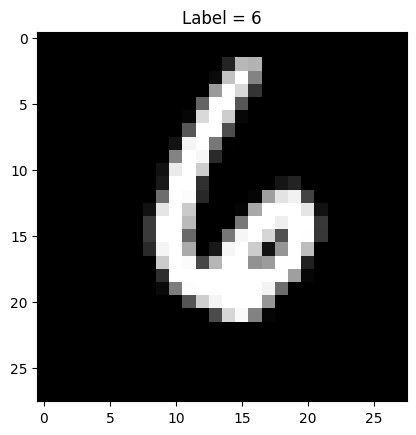

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Predicted: 6


In [ ]:
index = 0

import matplotlib.pyplot as plt
plt.imshow(X_test[index].reshape(28,28), cmap="gray")
plt.title(f"Label = {y_test[index]}")
plt.show()

pred = model.predict(X_test[index:index+1])
print("Predicted:", np.argmax(pred))
